In [1]:
from matplotlib.pyplot import *
import numpy as np
import h5py
from Data_Core.experiment import *
from Data_Core.digital_twin import *
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
import sklearn
%load_ext autoreload
from skimage import feature
import scipy
from skimage.filters import gabor
from skimage.filters import threshold_otsu

# Funções Base

In [2]:
def find_index(wavelenghts,w):
    return np.argmin(np.abs(wavelenghts - w))

In [3]:
def Raman_data_loader(filename):

    with h5py.File(filename, 'a') as output_file:
         
        properties = output_file['properties']
        
        exp_properties = {'step_size' : np.array(properties['step_size'])[0],
                          'speed' : np.array(properties['speed']),
                          'n_points' : np.array(properties['n_points'])
            }
        
        wavelengths = np.array(output_file['properties']['x_data'])
        
        
        spot_numbers = [int(s.split('_')[-1]) for s in list(output_file['data'].keys()) if 'spot' in s ]
        
        Nx,Ny = output_file['properties']['n_points'][0], output_file['properties']['n_points'][1]
        Nl = len(wavelengths)
        spectral_signal = np.zeros([Nx,Ny,Nl])
        
        
        for _i, spot_number in enumerate(spot_numbers):

            ix, iy = int(spot_number//Ny), int(spot_number%Ny)
            
            spot = 'spot_'+str(spot_number)
            data = np.array(output_file['data'][spot]['raw_data'])
                      
            spectral_signal[ix,iy,:] = data
            

    return spectral_signal, wavelengths, exp_properties

In [4]:
def read_data_map(file):
    hf = h5py.File(file, 'r')
    spectrums = np.array(hf.get('intensities'))
    positions = np.array(hf.get('position'))
    wavelengths = np.array(hf.get('wavelengths'))
    positions = np.delete(positions, 0, 0)
    spectrums = np.delete(spectrums, 0, 0)
    x = positions[:, 0]
    y = positions[:, 1]
    xy = np.lexsort((y, x))

    hf.close()
    return spectrums[xy], wavelengths, positions

In [5]:
from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als_optimized(y, lam, p, niter = 10):
    L = len(y)
    D = sparse.diags([1, -2, 1],[0, -1, -2], shape = (L, L - 2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z

In [6]:
def read_ref(mineral):
    df = pd.read_csv(mineral + '_raman.txt',header=13,names=['wavenumber','int'],skipfooter=4,engine='python' )
    return np.array(df['wavenumber']),np.array(df['int'])

# LIBS: FFT + thresholding + edge + texture HDR

In [7]:
file='C:/Users/Joana/Documents/Doutoramento/1 ano/spectral imaging/HDR/Comparação libs_raman/hdr_petalite_espodumeno.h5'
def read_data_map_2(file):
    # Open the HDF5 file in read mode
    with h5py.File(file, 'r') as hf:
        # Extract the datasets and convert them to numpy arrays
        spectrums = np.array(hf.get('intensities'))
        positions = np.array(hf.get('position'))
        wavelengths = np.array(hf.get('wavelengths'))

    # Return the data as is
    return spectrums, wavelengths, positions
spectrum, wavelengths, positions = read_data_map_2(file)

In [8]:
el=[610.22,588.99,309.27,288.13,777.194]
el_n=['Li','Na','Al','Si','O']

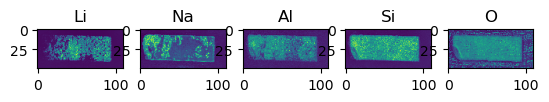

In [9]:
maps=spectrum.copy()
fig,ax=subplots(1,len(el))
for i in range(len(el)):
    ax[i].imshow(maps[find_index(wavelengths,el[i]),:,:])
    ax[i].set_title(el_n[i])

In [10]:
normalized_spec1=np.transpose(maps.reshape(-1,maps.shape[1],maps.shape[2]),axes=(1,2,0))

nx, ny = normalized_spec1.shape[1], normalized_spec1.shape[0]
dx = 0.5
dy = 0.5
 
freqs_x = 2*np.pi*np.fft.fftfreq(nx, dx)
freqs_y = 2*np.pi*np.fft.fftfreq(ny, dy)
 
def fft_feature(mmap, pixel_size_small):
    fft_map = np.array([np.fft.fftshift(np.fft.fft2(mmap[:, :, i])) for i in tqdm(range(0, (mmap.shape[-1])))])
    fft_map[:, fft_map.shape[1]//2, fft_map.shape[2]//2] = 0
 
    kxx, kyy = np.meshgrid(np.fft.fftshift(freqs_x), np.fft.fftshift(freqs_y))
 
    object_size_small = pixel_size_small*dx
    size_kspace_small = 2*np.pi/object_size_small/2*1.5
 
    R = abs(np.sqrt(kxx**2 + kyy**2))
 
    sum1 = np.sum(np.abs(fft_map[:,(R < size_kspace_small)]), axis = (1))
    max1 = np.sum(np.abs(fft_map), axis = (1, 2))
 
    sums = np.array(sum1)/np.array(max1)
 
    return sums, fft_map
 
sums, fft_m = fft_feature(normalized_spec1, 10)

100%|██████████| 16384/16384 [00:04<00:00, 3363.99it/s]


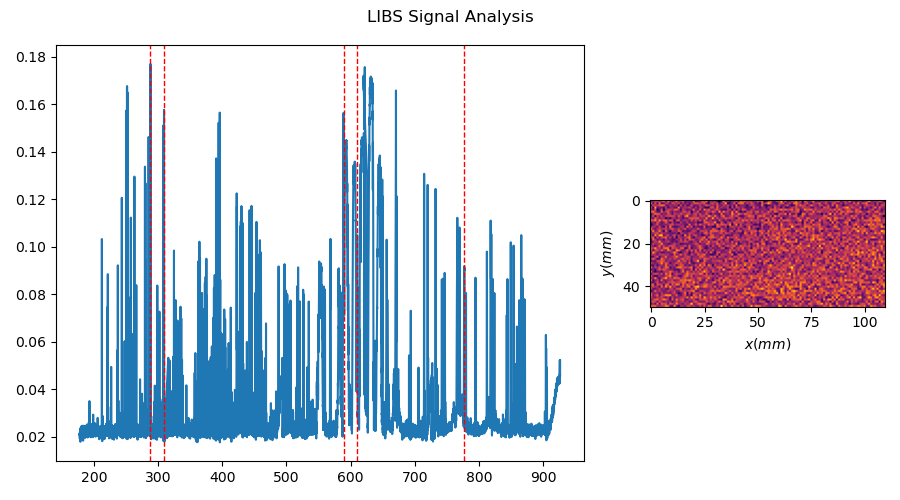

In [11]:

find_index = lambda wavelenghts,w : np.argmin(np.abs(wavelengths-w))
    
%matplotlib widget
fig, ax = subplots(1,2, figsize = (9, 5), gridspec_kw = {'width_ratios': [0.9, 0.4]})
fig.suptitle('LIBS Signal Analysis')

axs = ax[0]
axs.plot(wavelengths,sums)
for i in range(len(el)):
    axs.axvline(el[i],linestyle='--',color='red',lw=1)
axs = ax[1]
axs.imshow(maps[100,:, :], cmap = cm.inferno)
axs.set_xlabel(r'$x(mm)$')
axs.set_ylabel(r'$y(mm)$')



def update_map(wn):
    im = ax[1].imshow(maps[wn,:, :],
                     interpolation = 'none')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    wn = find_index(wavelengths, ix)
    if event.inaxes == ax[0] or ax0:
        update_map(wn)
        fig.canvas.draw_idle()
        
cid = fig.canvas.mpl_connect('button_press_event', onclick)
fig.tight_layout()

In [12]:
peaks=scipy.signal.find_peaks(sums)[0]
sel_maps=[]
sel_wavs=[]
heights=sums[peaks]
for i in range(len(peaks)):
    if heights[i]>0.11:
        sel_maps.append(maps[peaks[i]])
        sel_wavs.append([wavelengths[peaks[i]]])

sel_maps=np.array(sel_maps)
sel_maps=sel_maps.reshape(-1,maps.shape[1],maps.shape[2])

In [13]:
# para os mapas que estão dentro dos parametros da fft retirar os que tem sinal fora da rocha
sel_maps_f=sel_maps.reshape(-1,sel_maps.shape[1]*sel_maps.shape[2])
thresholds=np.array([threshold_otsu(sel_maps_f[i]) for i in range(sel_maps.shape[0])])
final_masks=[]
for map in range(len(thresholds)):
    c_mask=np.zeros(sel_maps_f.shape[1])
    for i in range(sel_maps_f.shape[1]):
        if sel_maps_f[map,i]>thresholds[map]:
            c_mask[i]=1
    final_masks.append(c_mask)

final_masks=np.array(final_masks).reshape(-1,sel_maps.shape[1],sel_maps.shape[2])


new_maps=[]
edge=[]
for w in tqdm(range(final_masks.shape[0])):
    current_map=final_masks[w,:,:]
    pixel_sum=np.sum(current_map[43:,:])
    if pixel_sum <1:
        new_maps.append(sel_maps[w,:,:])
new_maps=np.array(new_maps)
print(sel_maps.shape)
print(new_maps.shape)

100%|██████████| 180/180 [00:00<00:00, 25200.26it/s]

(180, 50, 110)
(22, 50, 110)


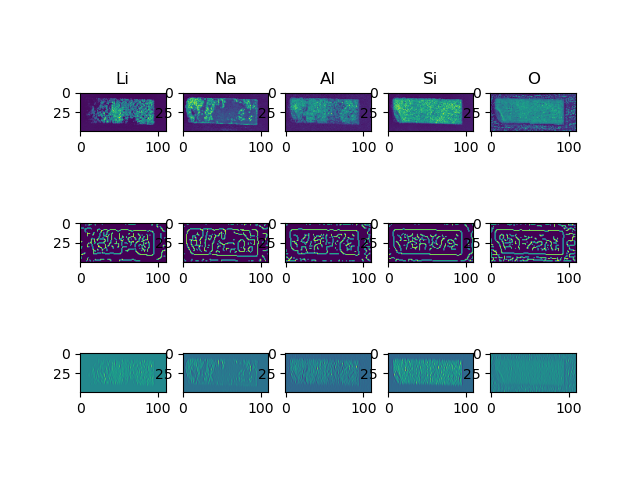

In [14]:
fig,ax=subplots(3,len(el))
for i in range(len(el)):
    c_map=maps[find_index(wavelengths,el[i]),:,:]
    ax[0,i].imshow(c_map)
    ax[0,i].set_title(el_n[i])
    ax[1,i].imshow(feature.canny(c_map*255,sigma=2))
    ax[2,i].imshow(gabor(c_map*255, frequency=0.6)[0])

In [15]:
edge_maps=[]
for w in tqdm(range(new_maps.shape[0])):
    current_map=new_maps[w,:,:]*255
    edges = feature.canny(current_map,sigma=1.5)
    edge_maps.append(edges)
edge_maps=np.array(edge_maps)
texture_maps=[]

for w in tqdm(range(new_maps.shape[0])):
    current_map=new_maps[w,:,:]
    filt_real, filt_imag = gabor(current_map, frequency=0.6) #lower f, more sensitivty to detail
    texture_maps.append(filt_real)
texture_maps=np.array(texture_maps)


100%|██████████| 22/22 [00:00<00:00, 773.41it/s]


In [16]:
n_clusters=4
kmeans = sklearn.cluster.KMeans(n_clusters = n_clusters,random_state=0)
 
new_features=new_maps*500#+edge_maps*10+texture_maps*400
features=new_features.reshape(-1,maps.shape[2]*maps.shape[1])
a=kmeans.fit_predict(features)
labels = kmeans.labels_
clusters_c = np.array(kmeans.cluster_centers_)

c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


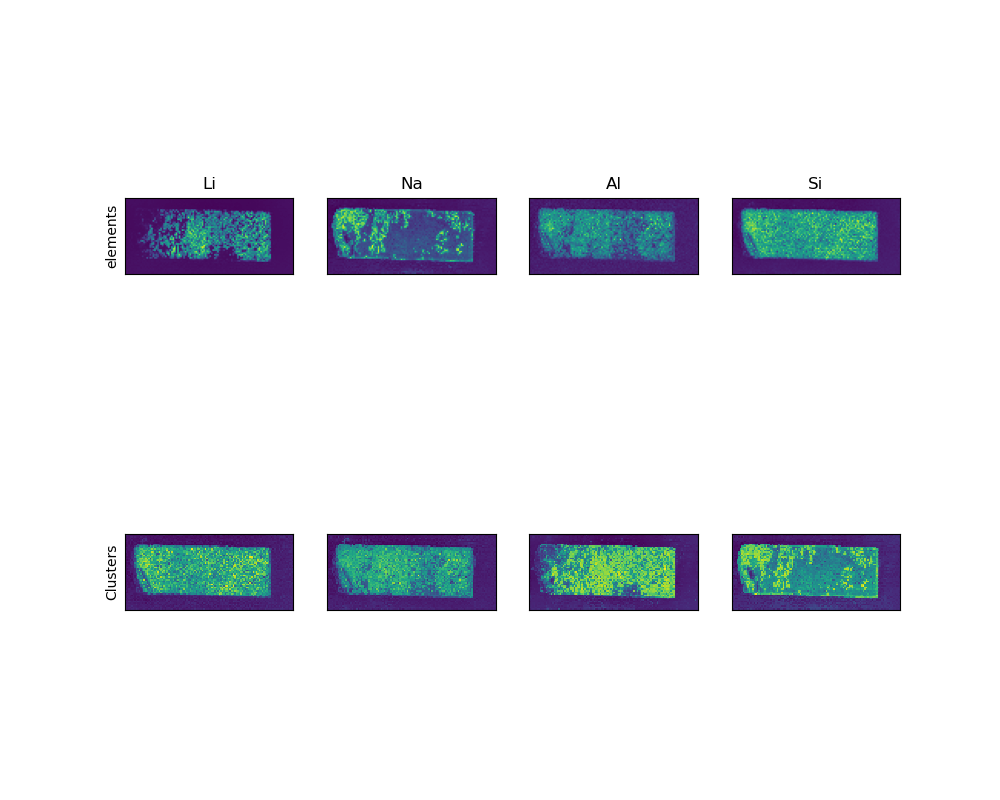

In [17]:
fig,ax=subplots(2,n_clusters,figsize=(10,8))
for i in range(n_clusters):
    if i<len(el):
        wav=find_index(wavelengths,el[i])
        ax[0,i].imshow(maps[wav,:,:])
        ax[0,i].set_title(el_n[i])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
    ax[0,0].set_ylabel('elements')
    ax[1,0].set_ylabel('Clusters')

    ax[1,i].imshow(clusters_c[i].reshape(maps.shape[1], maps.shape[2]), interpolation = 'none')

## Mineral Definition

### Thresholding

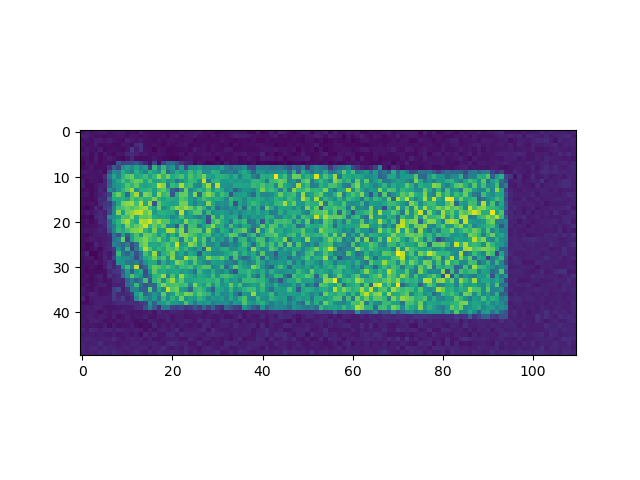

In [18]:
#definir area da imagem para thresholding
#cluster_label=['Al','Na','Si','O','Li']
cluster_label=['Si','Al','Li','Na']
clusters_reshaped=clusters_c.reshape(-1,maps.shape[1], maps.shape[2])
plt.figure()
plt.imshow(clusters_reshaped[0])
# x: [10:35]
# y: [20:90]

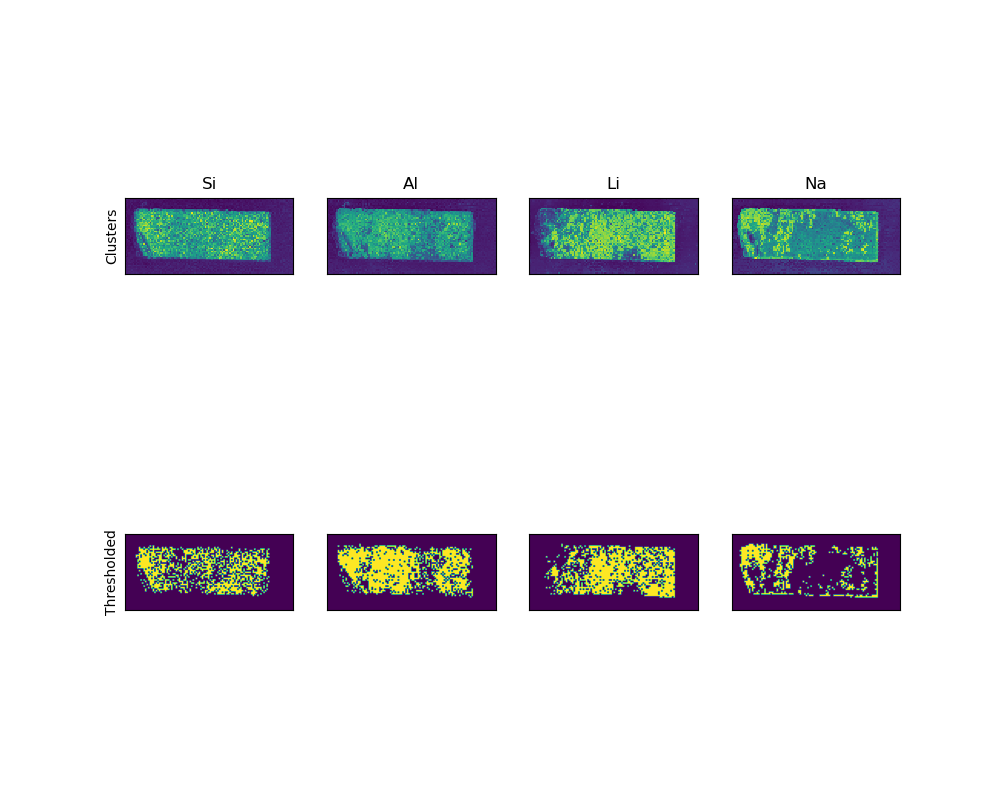

In [19]:
fig,ax=subplots(2,n_clusters,figsize=(10,8))
thresholded_clusters=[]

for i in range(n_clusters):
    ax[0,i].imshow(clusters_reshaped[i], interpolation = 'none')
    ax[0,i].set_title(cluster_label[i])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
    ax[0,0].set_ylabel('Clusters')


    t=threshold_otsu(clusters_reshaped[i,10:35,20:90])# a threshold tem de ser definida só dentro da amostra
    cluster_t=clusters_reshaped[i].copy()>t
    thresholded_clusters.append(cluster_t)
    ax[1,i].imshow(cluster_t)


    ax[1,0].set_ylabel('Thresholded')
thresholded_clusters=np.array(thresholded_clusters)

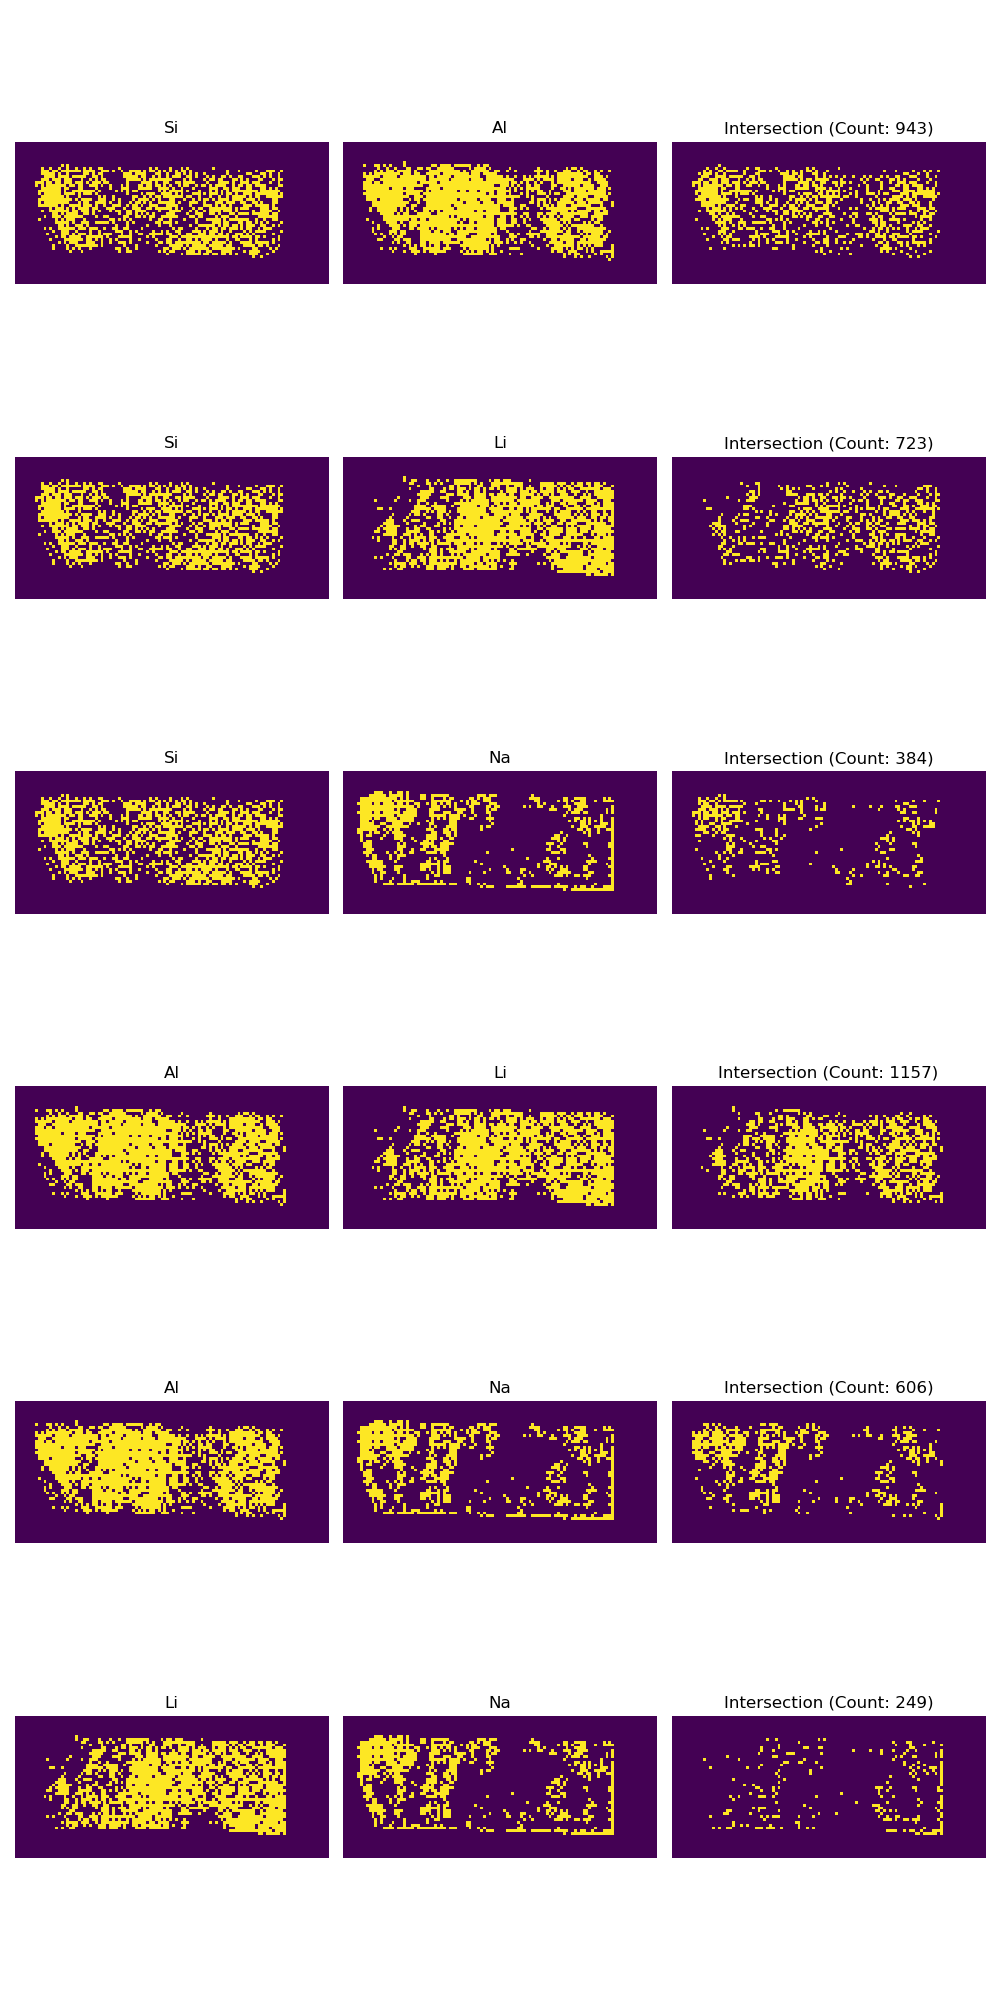

In [20]:
#interseções 2 a 2
excluded_indices = {}
valid_indices = [i for i in range(len(thresholded_clusters)) if i not in excluded_indices]

intersections = {}
fig, axes = plt.subplots(len(valid_indices) * (len(valid_indices) - 1) // 2, 3, figsize=(10, 5 * len(valid_indices)))

plot_index = 0
for i in valid_indices:
    for j in valid_indices:
        if i < j:  
            intersection = np.logical_and(thresholded_clusters[i], thresholded_clusters[j])
            intersection_count = np.sum(intersection)  


            intersections[(i, j)] = intersection_count

            ax1, ax2, ax3 = axes[plot_index]
            ax1.imshow(thresholded_clusters[i],interpolation='none')
            ax1.set_title(f'{cluster_label[i]}') 
            ax1.axis('off')

            ax2.imshow(thresholded_clusters[j], interpolation='none')
            ax2.set_title(f'{cluster_label[j]}')  
            ax2.axis('off')

            ax3.imshow(intersection,interpolation='none')
            ax3.set_title(f'Intersection (Count: {intersection_count})')
            ax3.axis('off')

            plot_index += 1

plt.tight_layout()
plt.show()

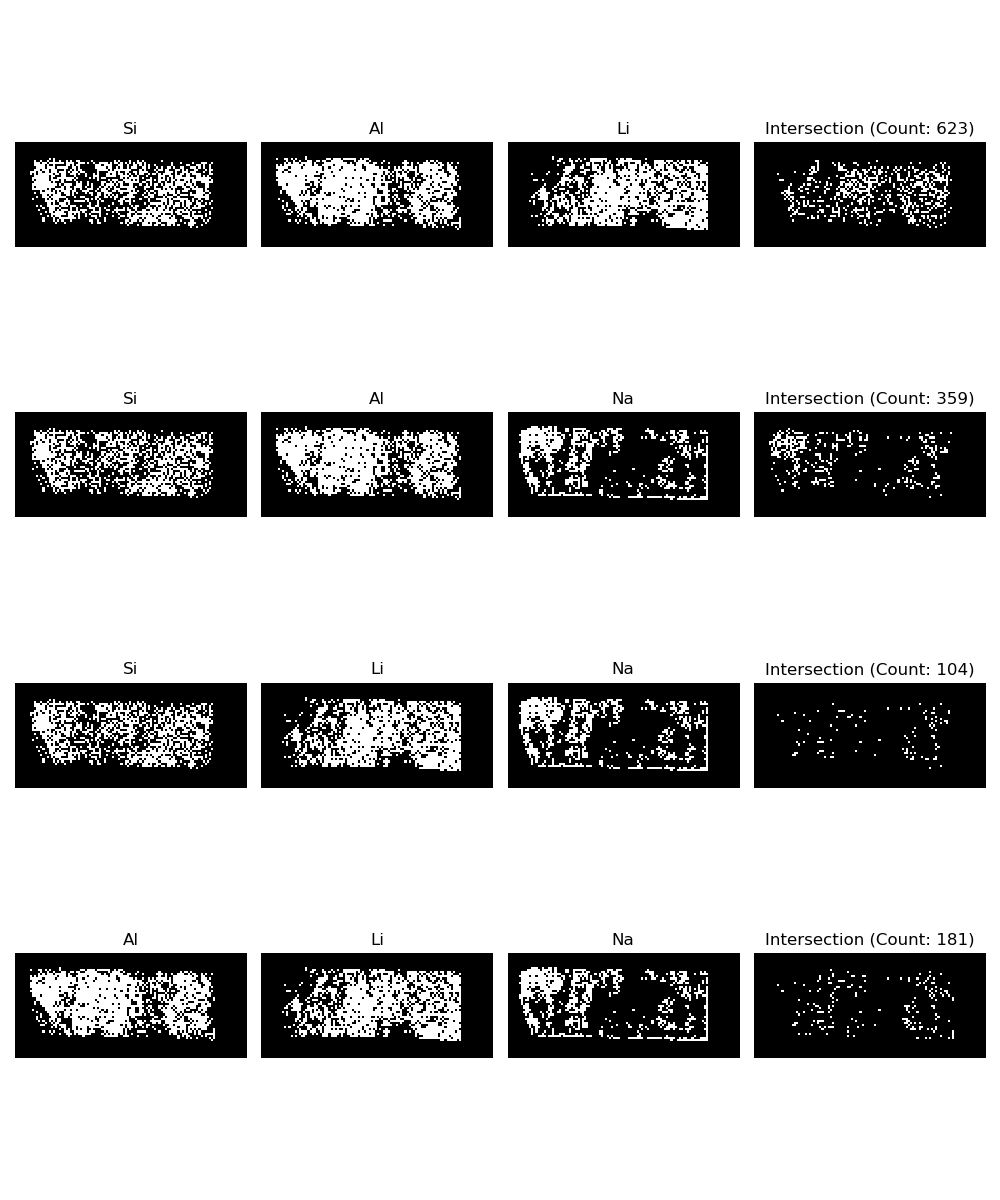

In [21]:
#interseções 3 a 3

# Prepare for plotting
intersections = {}
fig, axes = plt.subplots(
    len(valid_indices) * (len(valid_indices) - 1) * (len(valid_indices) - 2) // 6, 
    4, 
    figsize=(10, 3 * len(valid_indices))
)

plot_index = 0
for i in valid_indices:
    for j in valid_indices:
        for k in valid_indices:
            if i < j < k:  # To avoid duplicate pairs and self-comparisons
                # Calculate intersection as the element-wise logical AND for three clusters
                intersection = np.logical_and(
                    thresholded_clusters[i], 
                    np.logical_and(thresholded_clusters[j], thresholded_clusters[k])
                )
                intersection_count = np.sum(intersection)  # Count the number of intersecting elements

                # Store the result in a dictionary
                intersections[(i, j, k)] = intersection_count

                # Plot the three clusters and their intersection
                ax1, ax2, ax3, ax4 = axes[plot_index]
                ax1.imshow(thresholded_clusters[i], cmap='gray', interpolation='none')
                ax1.set_title(f'{cluster_label[i]}')  # Use the cluster name from cluster_label
                ax1.axis('off')

                ax2.imshow(thresholded_clusters[j], cmap='gray', interpolation='none')
                ax2.set_title(f'{cluster_label[j]}')  # Use the cluster name from cluster_label
                ax2.axis('off')

                ax3.imshow(thresholded_clusters[k], cmap='gray', interpolation='none')
                ax3.set_title(f'{cluster_label[k]}')  # Use the cluster name from cluster_label
                ax3.axis('off')

                ax4.imshow(intersection, cmap='gray', interpolation='none')
                ax4.set_title(f'Intersection (Count: {intersection_count})')
                ax4.axis('off')

                plot_index += 1

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

Text(0.5, 1.0, ' Counts: 101')

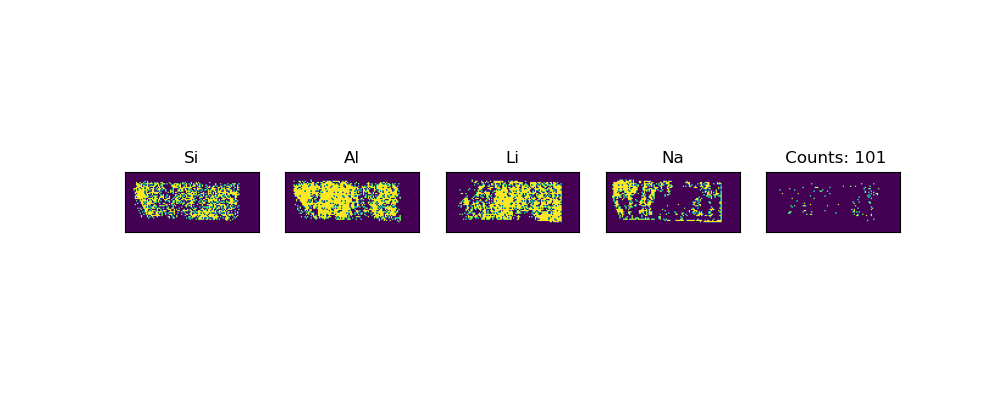

In [22]:
# todos os clusters
intse=thresholded_clusters[0]
for i in range(1,len(thresholded_clusters)):
    intse=np.logical_and(intse, thresholded_clusters[i])

fig,ax=subplots(1,len(thresholded_clusters)+1,figsize=(10,4))
for i in range(0,len(thresholded_clusters)):
    ax[i].imshow(thresholded_clusters[i])
    ax[i].set_title(cluster_label[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

ax[-1].imshow(intse)
ax[-1].set_xticks([])
ax[-1].set_yticks([])
intersection_count=np.sum(intse)
ax[-1].set_title(f' Counts: {intersection_count}')

In [23]:
selected_intersections = []
intersection_counts = []  
intersection_maps = []  

# Check 2x2 intersections
for i in valid_indices:
    for j in valid_indices:
        if i < j:
            intersection = np.logical_and(thresholded_clusters[i], thresholded_clusters[j])
            count = np.sum(intersection)
            label_string = f"{cluster_label[i]} & {cluster_label[j]}"
            selected_intersections.append(label_string)
            intersection_counts.append(count)
            intersection_maps.append(intersection)  

# Check 3x3 intersections
for i in valid_indices:
    for j in valid_indices:
        for k in valid_indices:
            if i < j < k:
                intersection = np.logical_and(
                    thresholded_clusters[i], 
                    np.logical_and(thresholded_clusters[j], thresholded_clusters[k])
                )
                count = np.sum(intersection)
                label_string = f"{cluster_label[i]} & {cluster_label[j]} & {cluster_label[k]}"
                selected_intersections.append(label_string)
                intersection_counts.append(count)
                intersection_maps.append(intersection)  

# Check 4x4 intersections
for i in valid_indices:
    for j in valid_indices:
        for k in valid_indices:
            for l in valid_indices:
                if i < j < k < l:
                    intersection = np.logical_and(
                        thresholded_clusters[i], 
                        np.logical_and(
                            thresholded_clusters[j], 
                            np.logical_and(thresholded_clusters[k], thresholded_clusters[l])
                        )
                    )
                    count = np.sum(intersection)
                    label_string = f"{cluster_label[i]} & {cluster_label[j]} & {cluster_label[k]} & {cluster_label[l]}"
                    selected_intersections.append(label_string)
                    intersection_counts.append(count)
                    intersection_maps.append(intersection)  
intersection_maps=np.array(intersection_maps)


In [24]:
print(selected_intersections)
print(intersection_counts)
print(np.array(intersection_maps).shape)

['Si & Al', 'Si & Li', 'Si & Na', 'Al & Li', 'Al & Na', 'Li & Na', 'Si & Al & Li', 'Si & Al & Na', 'Si & Li & Na', 'Al & Li & Na', 'Si & Al & Li & Na']
[943, 723, 384, 1157, 606, 249, 623, 359, 104, 181, 101]
(11, 50, 110)


In [25]:
# filtrar repetidos
int_final = []
index_selected = []

for i in tqdm(range(len(selected_intersections) - 2, 0, -1)):
    current = selected_intersections[i]
    elements = sorted(current.split(' & '), key=lambda x: x.strip())  

    is_subset = False
    for existing in int_final:
        if set(elements).issubset(set(existing)):  
            is_subset = True
            break

    if not is_subset:
        int_final.append(elements)
        index_selected.append(i)

        
selected_intersections_u = [selected_intersections[i] for i in index_selected]
intersection_counts_u = [intersection_counts[i] for i in index_selected]
intersection_maps_u = [intersection_maps[i] for i in index_selected]

100%|██████████| 9/9 [00:00<00:00, 9043.78it/s]


In [26]:
combined = list(zip(intersection_counts_u, selected_intersections_u,intersection_maps_u))
combined.sort(reverse=True, key=lambda x: x[0])

intersection_counts_u, selected_intersections_u, intersection_maps_u = zip(*combined)
intersection_counts_u = list(intersection_counts_u)
selected_intersections_u = list(selected_intersections_u)
intersection_maps_u = list(intersection_maps_u)

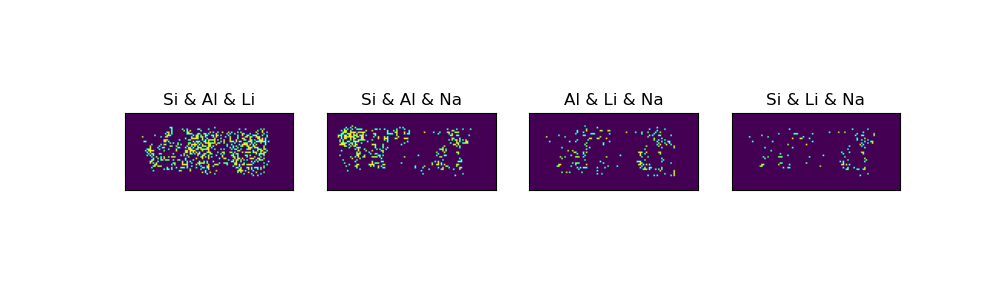

In [27]:

fig,ax=subplots(1,len(intersection_counts_u),figsize=(10,3))
for i in range(len(intersection_counts_u)):
    ax[i].imshow(intersection_maps_u[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(selected_intersections_u[i])

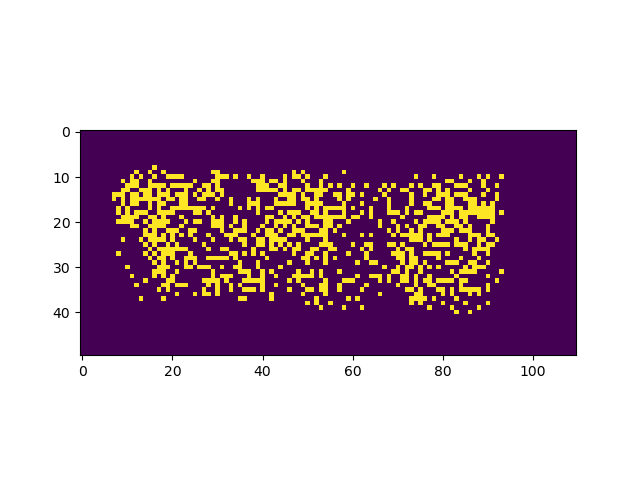

In [28]:
minerals=intersection_maps_u[:2]

base_map=logical_or(minerals[0],minerals[1])

plt.figure()
plt.imshow(base_map) # nao preenchem toda a amostra, falta algum mineral

In [29]:
## alguma das outras interseções completa?

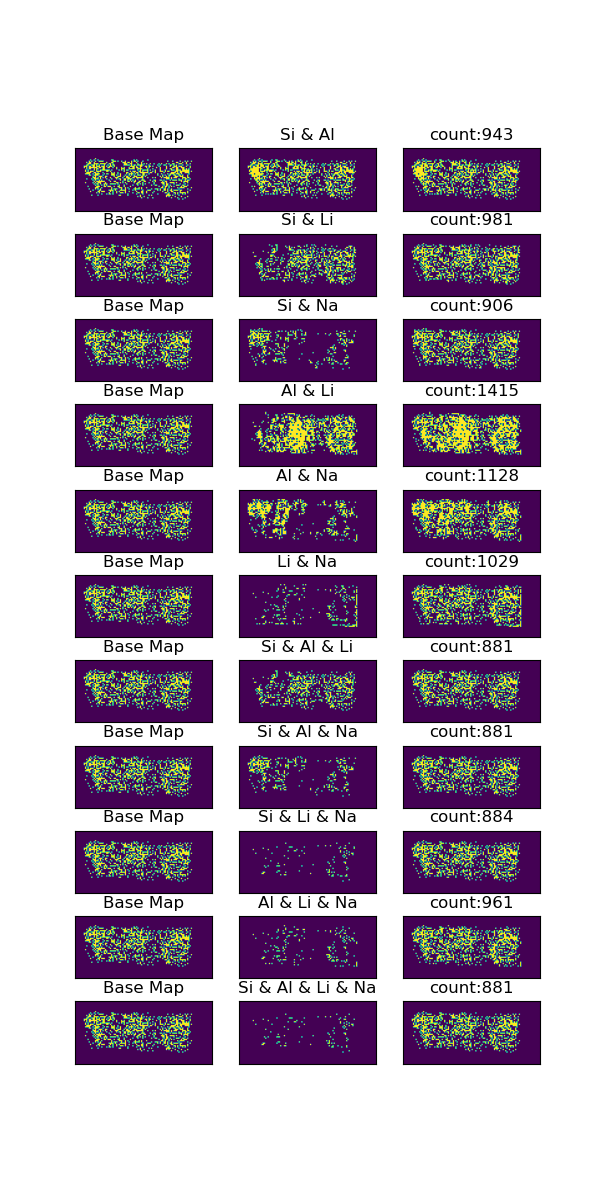

In [30]:
intersection_maps.shape
fig,ax=subplots(intersection_maps.shape[0],3,figsize=(6,12))
for i in range(intersection_maps.shape[0]):
    ax[i,0].imshow(base_map)
    ax[i,0].set_title('Base Map')
    ax[i,1].imshow(intersection_maps[i])
    ax[i,1].set_title(selected_intersections[i])
    map_or=np.logical_or(base_map,intersection_maps[i])
    ax[i,2].imshow(map_or)
    ax[i,2].set_title(f'count:{np.sum(map_or)}')

    for j in range(3):
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

#nenhuma completa

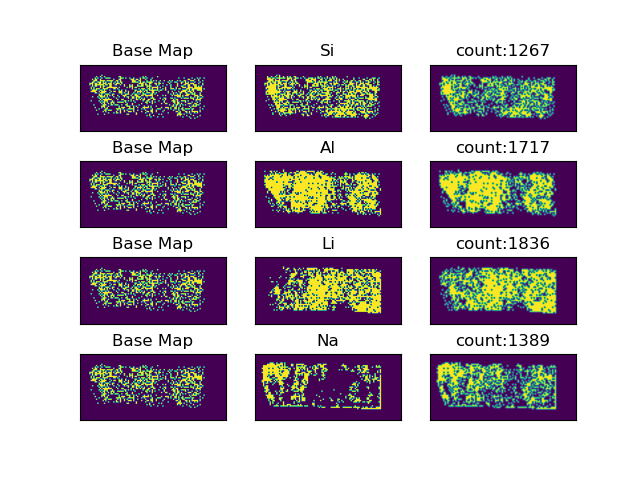

In [31]:
# e com um elemento só?

fig,ax=subplots(clusters_reshaped.shape[0],3)
for i in range(clusters_reshaped.shape[0]):
    ax[i,0].imshow(base_map)
    ax[i,0].set_title('Base Map')
    ax[i,1].imshow(thresholded_clusters[i])
    ax[i,1].set_title(cluster_label[i])
    map_or=np.logical_or(base_map,thresholded_clusters[i])
    ax[i,2].imshow(map_or,interpolation='gaussian')
    ax[i,2].set_title(f'count:{np.sum(map_or)}')

    for j in range(3):
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])



In [21]:
clusters_reshaped.shape

(4, 50, 110)

In [26]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
clusters_g=np.array(clusters_reshaped)
num_elements, x_size, y_size = clusters_reshaped.shape
data_reshaped = clusters_g.reshape(num_elements, -1).T  # Shape: (number of pixels, number of elements)

# Step 2: Perform hierarchical clustering
linkage_matrix = linkage(data_reshaped,method='average',metric='jaccard')  # 'ward' minimizes variance within clusters

# Step 3: Visualize the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Pixel Index")
plt.ylabel("Distance")
plt.show()


: 

In [22]:
distance_threshold = 0.8 # Adjust based on your data
clusters = fcluster(linkage_matrix, t=distance_threshold, criterion='distance')

# Step 5: Reshape the clusters back to the original image shape for visualization
cluster_map = clusters.reshape(x_size, y_size)

Text(0.5, 1.0, 'Clustered Mineral Map')

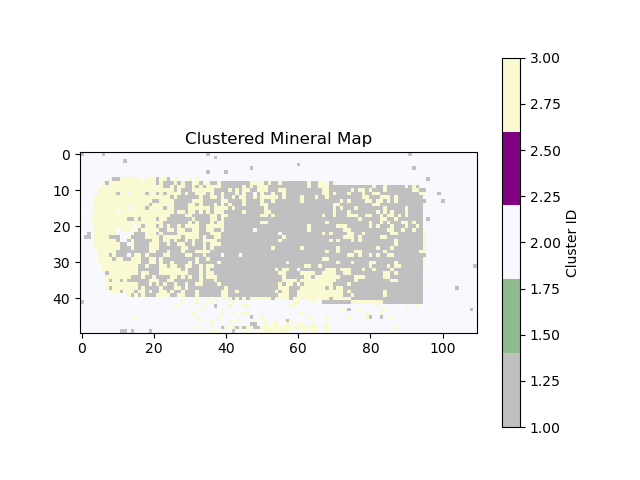

In [25]:
colors = [ 'silver','darkseagreen','ghostwhite','Purple', 'lightgoldenrodyellow',]
#mineral_list=['Muscovite','Albite','Quartz','Spodumene','Background']
from matplotlib.colors import ListedColormap
cmp_libs = ListedColormap(colors)
plt.figure()
plt.imshow(cluster_map,cmap=cmp_libs,interpolation='none')
plt.colorbar(label='Cluster ID')
plt.title("Clustered Mineral Map")

## com 5 clusters

In [33]:
n_clusters=5
kmeans = sklearn.cluster.KMeans(n_clusters = n_clusters,random_state=0)
 
new_features=new_maps*500#+edge_maps*10+texture_maps*400
features=new_features.reshape(-1,maps.shape[2]*maps.shape[1])
a=kmeans.fit_predict(features)
labels = kmeans.labels_
clusters_c = np.array(kmeans.cluster_centers_)

c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


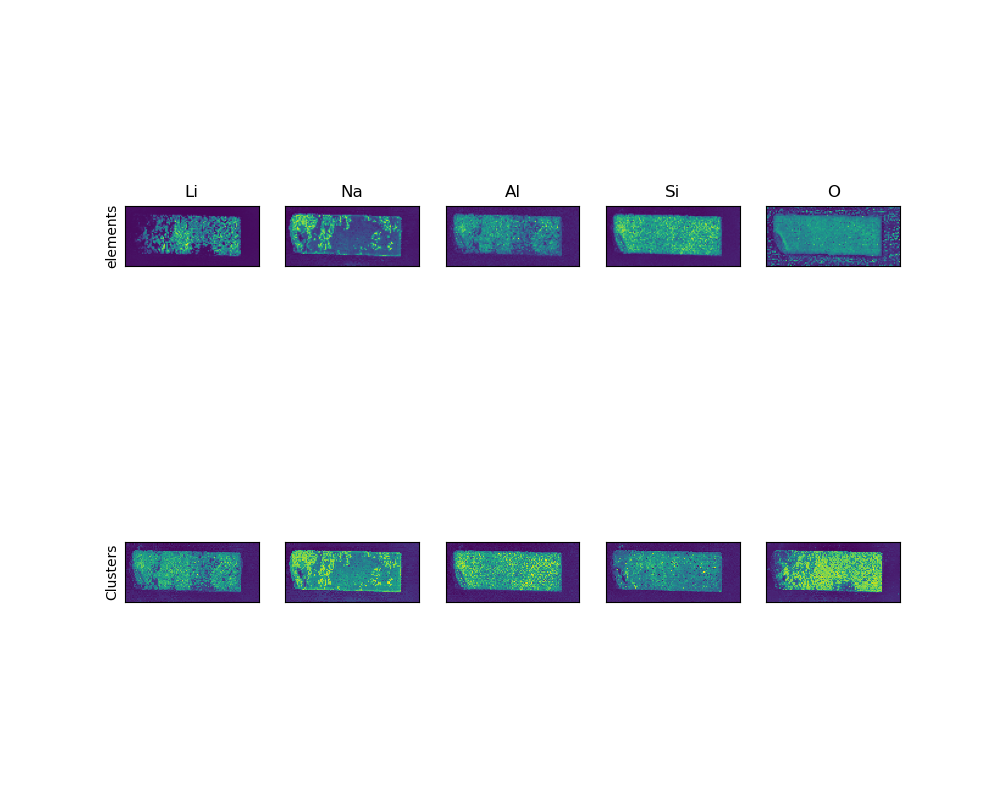

In [34]:
fig,ax=subplots(2,n_clusters,figsize=(10,8))
for i in range(n_clusters):
    if i<len(el):
        wav=find_index(wavelengths,el[i])
        ax[0,i].imshow(maps[wav,:,:])
        ax[0,i].set_title(el_n[i])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
    ax[0,0].set_ylabel('elements')
    ax[1,0].set_ylabel('Clusters')

    ax[1,i].imshow(clusters_c[i].reshape(maps.shape[1], maps.shape[2]), interpolation = 'none')

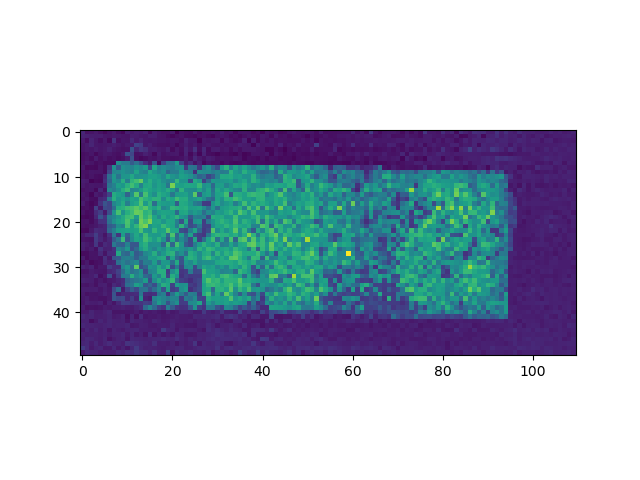

In [35]:
#definir area da imagem para thresholding
cluster_label=['Al','Na','Si','O','Li']
#cluster_label=['Si','Al','Li','Na']
clusters_reshaped=clusters_c.reshape(-1,maps.shape[1], maps.shape[2])
plt.figure()
plt.imshow(clusters_reshaped[0])
# x: [10:35]
# y: [20:90]

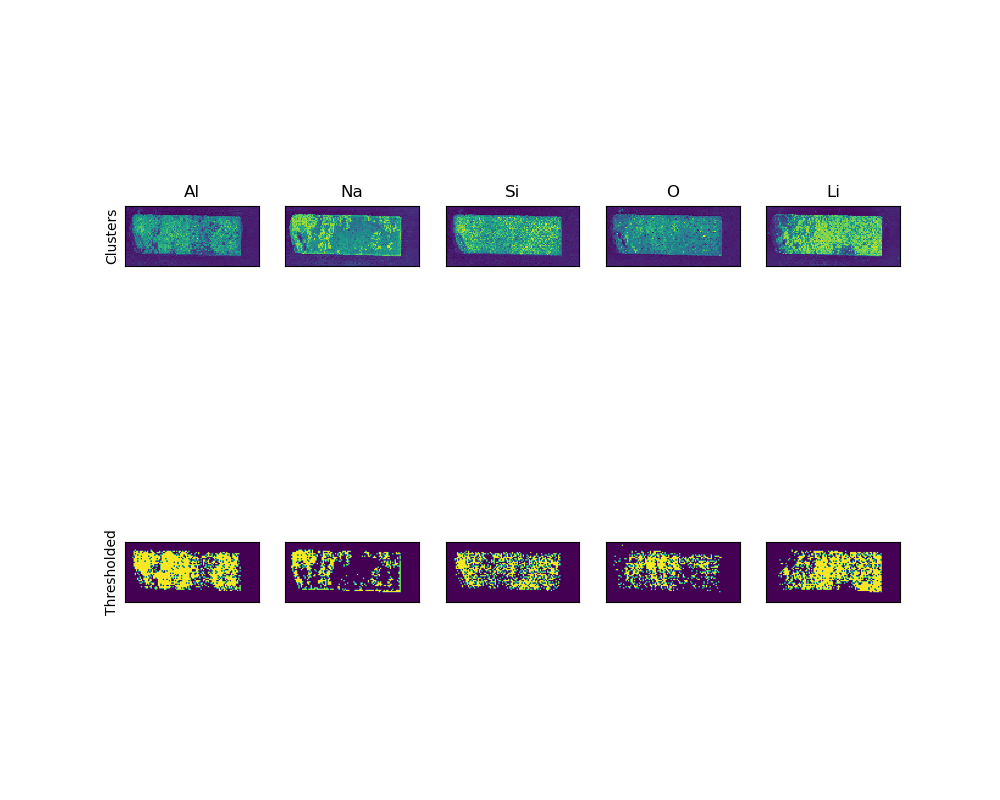

In [36]:
fig,ax=subplots(2,n_clusters,figsize=(10,8))
thresholded_clusters=[]

for i in range(n_clusters):
    ax[0,i].imshow(clusters_reshaped[i], interpolation = 'none')
    ax[0,i].set_title(cluster_label[i])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
    ax[0,0].set_ylabel('Clusters')


    t=threshold_otsu(clusters_reshaped[i,10:35,20:90])# a threshold tem de ser definida só dentro da amostra
    cluster_t=clusters_reshaped[i].copy()>t
    thresholded_clusters.append(cluster_t)
    ax[1,i].imshow(cluster_t)


    ax[1,0].set_ylabel('Thresholded')
thresholded_clusters=np.array(thresholded_clusters)

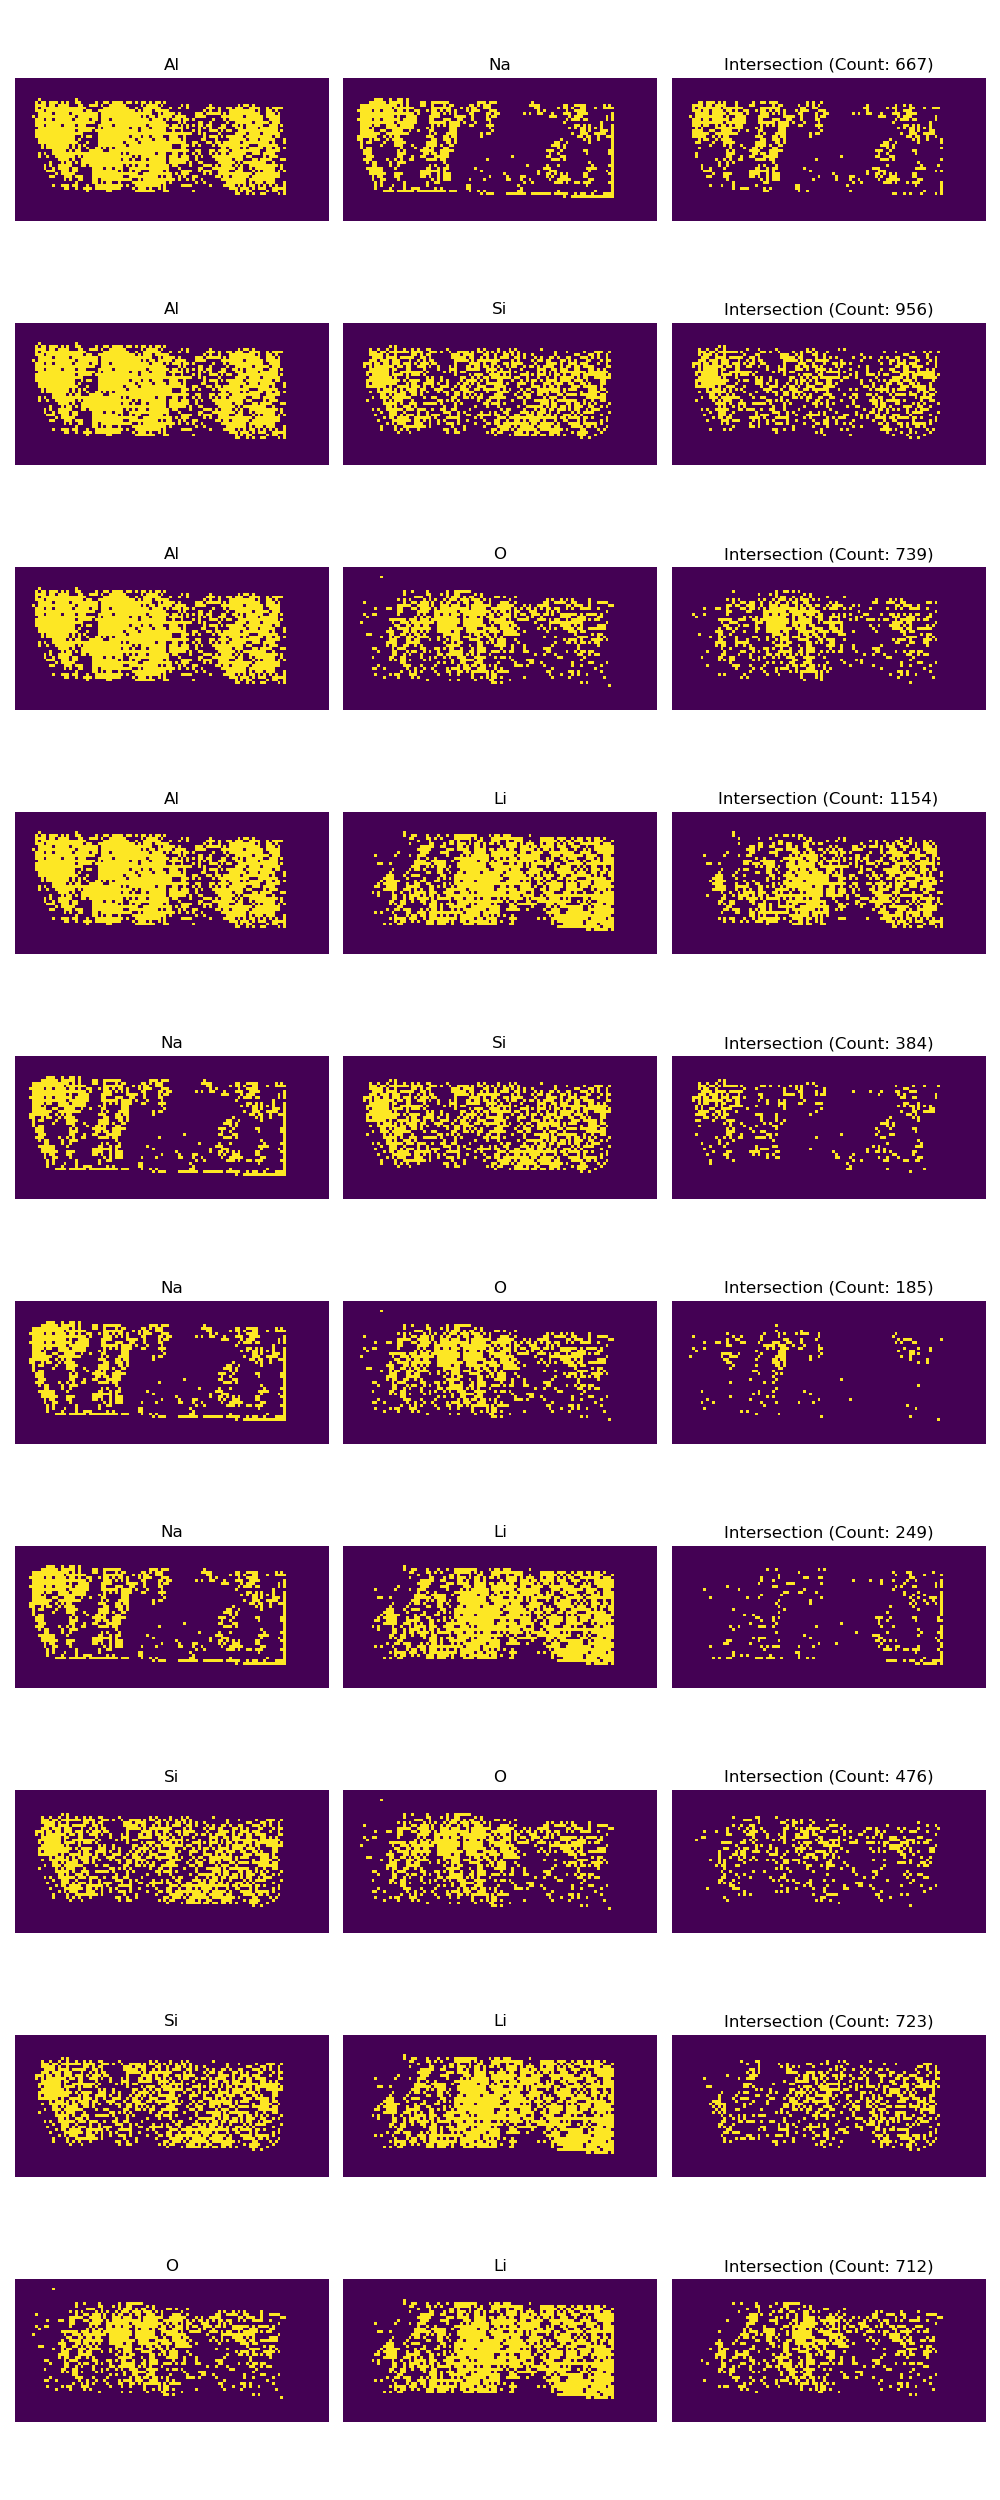

In [37]:
#interseções 2 a 2
excluded_indices = {}
valid_indices = [i for i in range(len(thresholded_clusters)) if i not in excluded_indices]

intersections = {}
fig, axes = plt.subplots(len(valid_indices) * (len(valid_indices) - 1) // 2, 3, figsize=(10, 5 * len(valid_indices)))

plot_index = 0
for i in valid_indices:
    for j in valid_indices:
        if i < j:  
            intersection = np.logical_and(thresholded_clusters[i], thresholded_clusters[j])
            intersection_count = np.sum(intersection)  


            intersections[(i, j)] = intersection_count

            ax1, ax2, ax3 = axes[plot_index]
            ax1.imshow(thresholded_clusters[i],interpolation='none')
            ax1.set_title(f'{cluster_label[i]}') 
            ax1.axis('off')

            ax2.imshow(thresholded_clusters[j], interpolation='none')
            ax2.set_title(f'{cluster_label[j]}')  
            ax2.axis('off')

            ax3.imshow(intersection,interpolation='none')
            ax3.set_title(f'Intersection (Count: {intersection_count})')
            ax3.axis('off')

            plot_index += 1

plt.tight_layout()
plt.show()

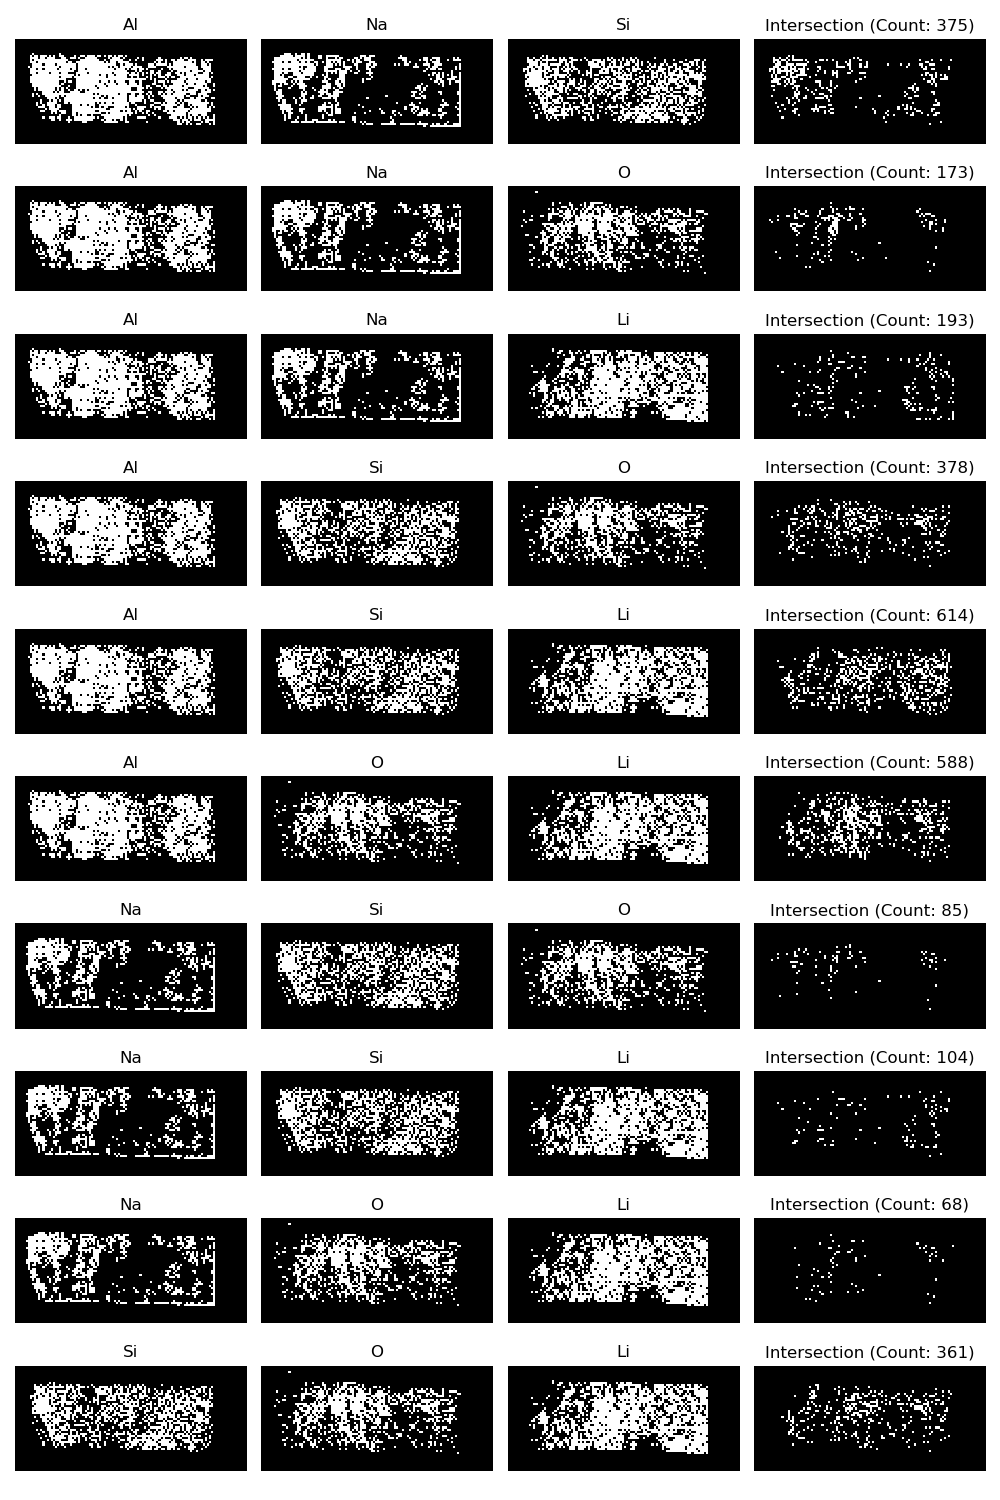

In [38]:
#interseções 3 a 3

# Prepare for plotting
intersections = {}
fig, axes = plt.subplots(
    len(valid_indices) * (len(valid_indices) - 1) * (len(valid_indices) - 2) // 6, 
    4, 
    figsize=(10, 3 * len(valid_indices))
)

plot_index = 0
for i in valid_indices:
    for j in valid_indices:
        for k in valid_indices:
            if i < j < k:  # To avoid duplicate pairs and self-comparisons
                # Calculate intersection as the element-wise logical AND for three clusters
                intersection = np.logical_and(
                    thresholded_clusters[i], 
                    np.logical_and(thresholded_clusters[j], thresholded_clusters[k])
                )
                intersection_count = np.sum(intersection)  # Count the number of intersecting elements

                # Store the result in a dictionary
                intersections[(i, j, k)] = intersection_count

                # Plot the three clusters and their intersection
                ax1, ax2, ax3, ax4 = axes[plot_index]
                ax1.imshow(thresholded_clusters[i], cmap='gray', interpolation='none')
                ax1.set_title(f'{cluster_label[i]}')  # Use the cluster name from cluster_label
                ax1.axis('off')

                ax2.imshow(thresholded_clusters[j], cmap='gray', interpolation='none')
                ax2.set_title(f'{cluster_label[j]}')  # Use the cluster name from cluster_label
                ax2.axis('off')

                ax3.imshow(thresholded_clusters[k], cmap='gray', interpolation='none')
                ax3.set_title(f'{cluster_label[k]}')  # Use the cluster name from cluster_label
                ax3.axis('off')

                ax4.imshow(intersection, cmap='gray', interpolation='none')
                ax4.set_title(f'Intersection (Count: {intersection_count})')
                ax4.axis('off')

                plot_index += 1

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

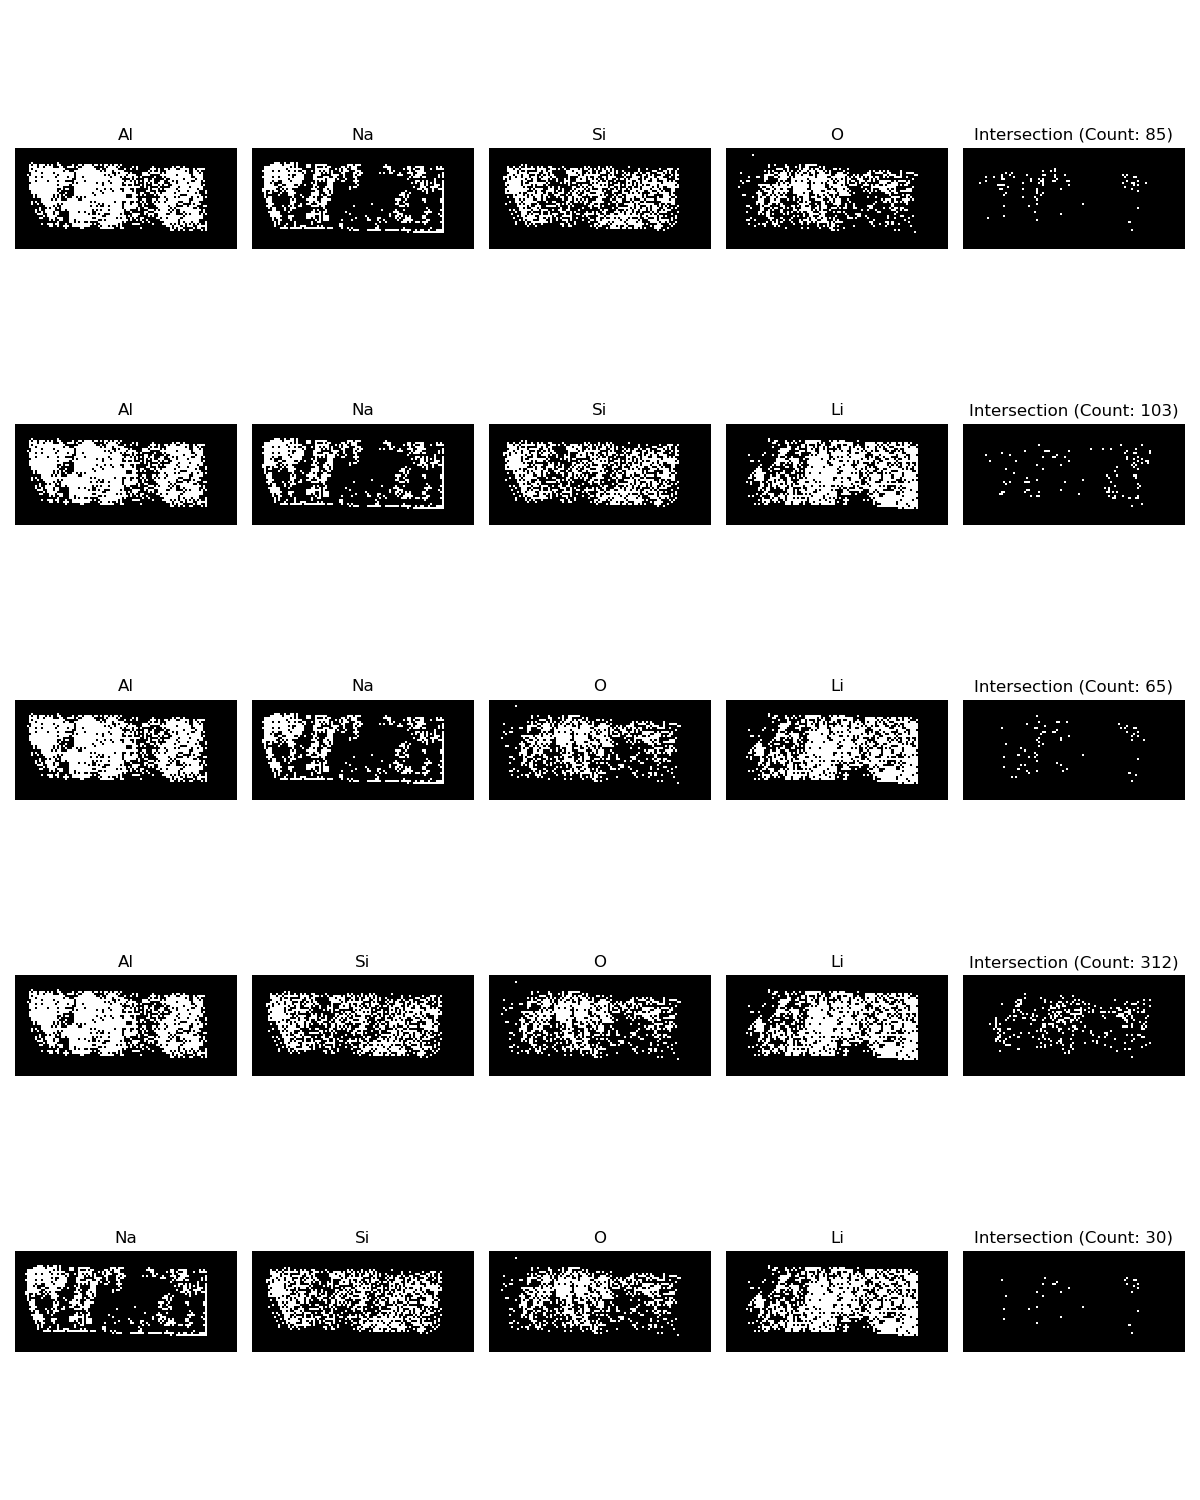

In [39]:
# Interseções 4 a 4

# Prepare for plotting
intersections = {}
# Adjusting the number of subplots to accommodate 4x4 intersections
fig, axes = plt.subplots(
    len(valid_indices) * (len(valid_indices) - 1) * (len(valid_indices) - 2) * (len(valid_indices) - 3) // 24, 
    5, 
    figsize=(12, 3 * len(valid_indices))
)

plot_index = 0
for i in valid_indices:
    for j in valid_indices:
        for k in valid_indices:
            for l in valid_indices:
                if i < j < k < l:  # To avoid duplicate pairs and self-comparisons
                    # Calculate intersection as the element-wise logical AND for four clusters
                    intersection = np.logical_and(
                        thresholded_clusters[i], 
                        np.logical_and(
                            thresholded_clusters[j], 
                            np.logical_and(thresholded_clusters[k], thresholded_clusters[l])
                        )
                    )
                    intersection_count = np.sum(intersection)  # Count the number of intersecting elements

                    # Store the result in a dictionary
                    intersections[(i, j, k, l)] = intersection_count

                    # Plot the four clusters and their intersection
                    ax1, ax2, ax3, ax4, ax5 = axes[plot_index]
                    ax1.imshow(thresholded_clusters[i], cmap='gray', interpolation='none')
                    ax1.set_title(f'{cluster_label[i]}')  # Use the cluster name from cluster_label
                    ax1.axis('off')

                    ax2.imshow(thresholded_clusters[j], cmap='gray', interpolation='none')
                    ax2.set_title(f'{cluster_label[j]}')  # Use the cluster name from cluster_label
                    ax2.axis('off')

                    ax3.imshow(thresholded_clusters[k], cmap='gray', interpolation='none')
                    ax3.set_title(f'{cluster_label[k]}')  # Use the cluster name from cluster_label
                    ax3.axis('off')

                    ax4.imshow(thresholded_clusters[l], cmap='gray', interpolation='none')
                    ax4.set_title(f'{cluster_label[l]}')  # Use the cluster name from cluster_label
                    ax4.axis('off')

                    ax5.imshow(intersection, cmap='gray', interpolation='none')
                    ax5.set_title(f'Intersection (Count: {intersection_count})')
                    ax5.axis('off')

                    plot_index += 1

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [40]:
# Na Al Si O devia dar mais alto

Text(0.5, 1.0, ' Counts: 30')

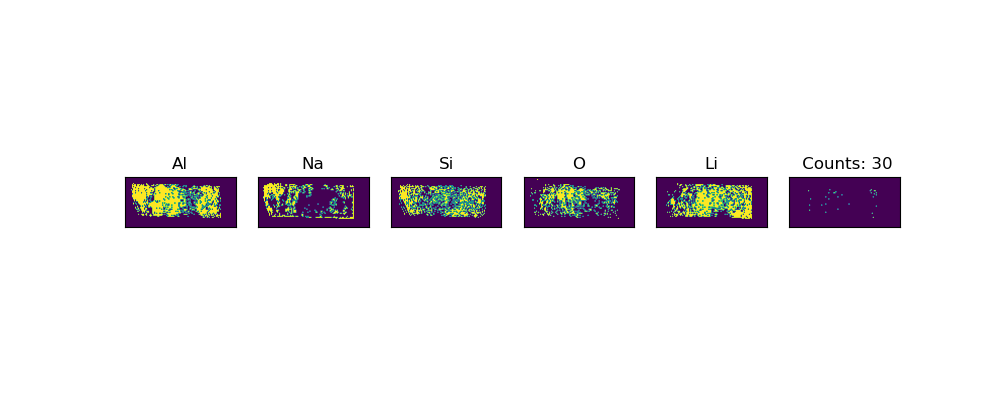

In [41]:
# todos os clusters
intse=thresholded_clusters[0]
for i in range(1,len(thresholded_clusters)):
    intse=np.logical_and(intse, thresholded_clusters[i])

fig,ax=subplots(1,len(thresholded_clusters)+1,figsize=(10,4))
for i in range(0,len(thresholded_clusters)):
    ax[i].imshow(thresholded_clusters[i])
    ax[i].set_title(cluster_label[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

ax[-1].imshow(intse)
ax[-1].set_xticks([])
ax[-1].set_yticks([])
intersection_count=np.sum(intse)
ax[-1].set_title(f' Counts: {intersection_count}')

In [42]:
selected_intersections = []
intersection_counts = []  
intersection_maps = []  

# Check 2x2 intersections
for i in valid_indices:
    for j in valid_indices:
        if i < j:
            intersection = np.logical_and(thresholded_clusters[i], thresholded_clusters[j])
            count = np.sum(intersection)
            label_string = f"{cluster_label[i]} & {cluster_label[j]}"
            selected_intersections.append(label_string)
            intersection_counts.append(count)
            intersection_maps.append(intersection)  

# Check 3x3 intersections
for i in valid_indices:
    for j in valid_indices:
        for k in valid_indices:
            if i < j < k:
                intersection = np.logical_and(
                    thresholded_clusters[i], 
                    np.logical_and(thresholded_clusters[j], thresholded_clusters[k])
                )
                count = np.sum(intersection)
                label_string = f"{cluster_label[i]} & {cluster_label[j]} & {cluster_label[k]}"
                selected_intersections.append(label_string)
                intersection_counts.append(count)
                intersection_maps.append(intersection)  

# Check 4x4 intersections
for i in valid_indices:
    for j in valid_indices:
        for k in valid_indices:
            for l in valid_indices:
                if i < j < k < l:
                    intersection = np.logical_and(
                        thresholded_clusters[i], 
                        np.logical_and(
                            thresholded_clusters[j], 
                            np.logical_and(thresholded_clusters[k], thresholded_clusters[l])
                        )
                    )
                    count = np.sum(intersection)
                    label_string = f"{cluster_label[i]} & {cluster_label[j]} & {cluster_label[k]} & {cluster_label[l]}"
                    selected_intersections.append(label_string)
                    intersection_counts.append(count)
                    intersection_maps.append(intersection)  
intersection_maps=np.array(intersection_maps)


# Initialize the final list and selected indices
int_final = []
index_selected = []

# Iterate through the intersections in reverse order (from the largest to the smallest)
for i in tqdm(range(len(selected_intersections) - 1, -1, -1)):
    current = selected_intersections[i]
    elements = sorted(current.split(' & '), key=lambda x: x.strip())  # Sort elements to ensure consistency

    is_subset = False
    for existing in int_final:
        # Check if the current intersection is a subset of any existing one
        if set(elements).issubset(set(existing)):
            # If the current intersection has a smaller pixel count, ignore it
            current_count = intersection_counts[i]
            existing_index = int_final.index(existing)
            existing_count = intersection_counts[index_selected[existing_index]]
            
            # If current intersection has fewer pixels, skip it
            if current_count <= existing_count:
                is_subset = True
                break  # If the current intersection is smaller, skip it
            else:
                # If the current one has more pixels, remove the existing one and replace it
                del int_final[existing_index]
                del index_selected[existing_index]
                break  # Stop checking further

    # If the current intersection is not a subset, save it
    if not is_subset:
        int_final.append(elements)
        index_selected.append(i)

# Now selected_intersections_u contains only the largest intersections
selected_intersections_u = [selected_intersections[i] for i in index_selected]
intersection_counts_u = [intersection_counts[i] for i in index_selected]
intersection_maps_u = [intersection_maps[i] for i in index_selected]
